In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install pyforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=f3e6082bca2f23abbaa2acd2028d9450c7e9092d5d9d2c2e5ddefcfc1608ae02
  Stored in directory: /root/.cache/pip/wheels/21/2d/19/8b5488f0caea6d892333413745640532d40d70e6b5351d7633
Successfully built pyforest


In [4]:
pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pyforest
import lazypredict
from lazypredict.Supervised import LazyClassifier
import warnings
warnings.filterwarnings("ignore")

### Import Packages

In [6]:
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from statistics import mean

# open source implementation of LBP
from skimage.feature import local_binary_pattern
# data preprocessing and metrics module in scikit-learn
from sklearn import preprocessing, metrics
# SVM implementation in scikit-learn
from sklearn.svm import LinearSVC
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import RidgeClassifierCV



### Local Binary Patterns

In [7]:
def lbp(arr):

    # LBP params
    radius = 3 # radius of coverage of surrounding pixels
    points = 8 * radius # 8 points will be around every pixel, 24 points or possible encoding patterns around the pixel of interest
    # 8 and 3 are standard values
    bins = points + 2
    lbp = local_binary_pattern(arr, points, radius, 'uniform') # outputs a larger list of arrays totalling 6724
    lbp = lbp.ravel() # make the list of arrays into one large list
    feature = np.zeros(bins)
    for i in lbp:
        feature[int(i)] += 1 # count the occurance of each value
    feature /= np.linalg.norm(feature, ord=1) # normalize the features
    return feature

### Load Data

In [8]:
def load_data(tag='train'):

    tag_dir = Path.cwd() / tag # get the file directory
    vec = []
    cat = []
    for cat_dir in tag_dir.iterdir():# iterate through the directory
        cat_label = cat_dir.stem # get labled photo names
        for img_path in tqdm(cat_dir.glob('*.jpeg')): # get files that are jpeg
            img = Image.open(img_path.as_posix()) # open each jpeg
            if img.mode != 'L': # if not greyscale convert with this conditional loop
                img = ImageOps.grayscale(img)
                img.save(img_path.as_posix())
            arr = np.array(img) #convert into array
            feature = lbp(arr) # get feature vectors
            vec.append(feature) #append to feature vector list
            cat.append(cat_label) # append to cat_label list
    return vec, cat

# train photos
vec_train, cat_train = load_data('drive/MyDrive/LBP/train')
# test photos
vec_test, cat_test   = load_data('drive/MyDrive/LBP/test')

0it [00:00, ?it/s]
194it [00:24,  8.05it/s]
896it [00:49, 18.07it/s]
0it [00:00, ?it/s]
108it [00:06, 17.21it/s]
137it [00:08, 15.56it/s]


In [9]:
#split the photo and print features in traning set
photo_label = cat_train[195:897]
print_label = cat_train[:194]

In [10]:
#split the photo and print categories in traning set
photo_vec = vec_train[195 :897]
print_vec = vec_train[:194]

In [11]:
# prepare features for histogram
photo_vec_hist = np.concatenate(photo_vec, axis=0 )
print_vec_hist = np.concatenate(print_vec, axis=0 )

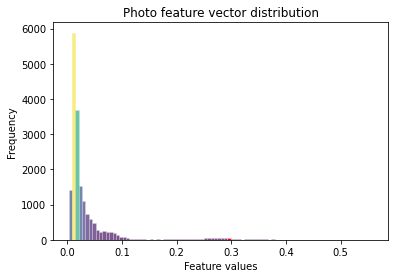

In [12]:
n, bins, patches = plt.hist(photo_vec_hist, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') 
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

patches[47].set_fc('red') # Set color
patches[47].set_alpha(1) # Set opacity

plt.title('Photo feature vector distribution', fontsize=12)
plt.xlabel('Feature values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()
  

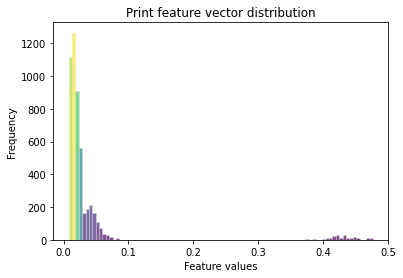

In [13]:
n, bins, patches = plt.hist(print_vec_hist, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') 

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

patches[47].set_fc('red') # Set color
patches[47].set_alpha(1) # Set opacity
plt.title('Print feature vector distribution', fontsize=12)
plt.xlabel('Feature values', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()
  

### List the categories

In [14]:
# get unique categories 
labels = list(np.unique(np.array(cat_train)))
labels

['Photo', 'Print']

### Label Encoder

In [15]:
# encode the photo and print vectors as a binary classification
le = preprocessing.LabelEncoder()
label_train = le.fit_transform(cat_train)
label_test = le.transform(cat_test)

In [16]:
#create the final format for feature vectors
vec_train_2 = np.array(vec_train)
vec_test_2 = np.array(vec_test)

##Lazy predict

In [17]:
clf_lazy = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf_lazy.fit(vec_train_2, vec_test_2, label_train, label_test)
models

100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RidgeClassifierCV,1.00,1.00,1.00,1.00,0.02
RidgeClassifier,1.00,1.00,1.00,1.00,0.02
LinearDiscriminantAnalysis,1.00,1.00,1.00,1.00,0.04
Perceptron,0.99,0.99,0.99,0.99,0.01
LabelPropagation,0.96,0.97,0.97,0.96,0.07
LabelSpreading,0.96,0.97,0.97,0.96,0.11
KNeighborsClassifier,0.96,0.97,0.97,0.96,0.03
AdaBoostClassifier,0.95,0.96,0.96,0.95,0.21
LogisticRegression,0.94,0.95,0.95,0.94,0.05


##KNN: Hyperparam. tuning and Kfold cross val.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(vec_train, label_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
#Perform hyperparamter tuning on the KNN
param_distributions_knn = { 'n_neighbors': uniform(1, 10) }
rnd_search_cv_knn= RandomizedSearchCV(neigh, param_distributions_knn, n_iter=20, verbose=2, cv=3)

In [20]:
from sklearn.model_selection import GridSearchCV
k_range=list(range(1,31))
print(k_range)
param_grid=dict(n_neighbors=k_range)
knn=KNeighborsClassifier()  #Important to form an instance
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(vec_train, label_train)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [21]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

1.0
{'n_neighbors': 1}
KNeighborsClassifier(n_neighbors=1)


In [22]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(vec_train, label_train)

KNeighborsClassifier(n_neighbors=1)

### Evaluation of KNN

Accuracy: 95.10%


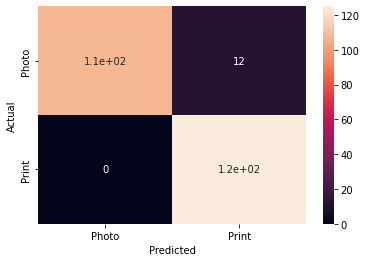

In [23]:
# test set evaluation
prediction = neigh.predict(vec_test)
# visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [24]:
#Knn cross value
k_range = list(range(1, 25))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, vec_train, label_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9963302752293579, 0.9963302752293579, 0.9935779816513761, 0.9935779816513761, 0.9935779816513761, 0.9917431192660551, 0.9917431192660551, 0.9880733944954129, 0.9871559633027523, 0.9871559633027523, 0.9871559633027523, 0.9889908256880734, 0.9880733944954129, 0.9880733944954129, 0.9871559633027523, 0.9871559633027523, 0.9871559633027523, 0.9871559633027523]


In [25]:
mean(k_scores)

0.9925076452599388

## Based on the Lazypredictor values it seems like models like RidgeClassifiers and LDA might be better and they won't need much tuning.

##RidgeClassifierCV

In [26]:
clf_rid = RidgeClassifierCV().fit(vec_train, label_train)

# Evaluation of RidgeClassifierCV

Accuracy: 92.65%


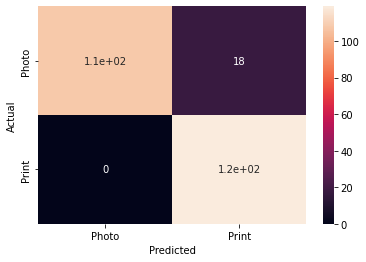

In [27]:
# test set evaluation
prediction = clf_rid.predict(vec_test)
# visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

##LDA

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [29]:
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(vec_train, label_train)

LinearDiscriminantAnalysis()

Accuracy: 100.00%


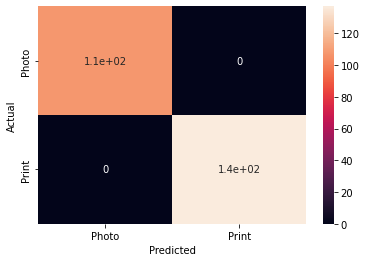

In [30]:
# test set evaluation
prediction = clf_LDA.predict(vec_test)
# visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

# LDA Evaluation


##Evaluation on test

In [31]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=30, n_repeats=3, random_state=1)
from numpy import mean
from numpy import std

scores = cross_val_score(clf_LDA, vec_test, label_test , scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

<IPython.core.display.Javascript object>

Mean Accuracy: 1.000 (0.000)


##Evaluation on train

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=30, n_repeats=3, random_state=1)
from numpy import mean
from numpy import std

scores = cross_val_score(clf_LDA, vec_train, label_train , scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

<IPython.core.display.Javascript object>

Mean Accuracy: 0.991 (0.014)


Interesting that runnning the K-fold cross validation, we get a less accuracte model on the training data then the test data. This might be that the test data is considerable smaller than the test data.|

## Why LDA performs so well?

LDA projections maximize the distances between different classes, it does this by maximizing the component class axes for class seperation. In other words, it gets a more seperate distributions between the classes on that axes. 

## Visualizing using T-SNE

In [33]:
print(vec_test_2.shape)
print(vec_train_2.shape)
print(len(cat_test))
print(len(cat_train))

(245, 26)
(1090, 26)
245
1090


In [34]:
from sklearn.manifold import TSNE
train_embedded = TSNE(n_components=2, learning_rate=200,
              init='random', perplexity=50).fit_transform(vec_train_2)
test_embedded = TSNE(n_components=2, learning_rate=200,
              init='random', perplexity=50).fit_transform(vec_test_2)

In [35]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1['y'] = cat_train
df2['y'] = cat_test
df1["comp-1"] = train_embedded [:,0]
df1["comp-2"] = train_embedded [:,1]
df2["comp-1"] = test_embedded [:,0]
df2["comp-2"] = test_embedded [:,1]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Text(0.5, 1.0, 'T-SNE projection of Training set')]

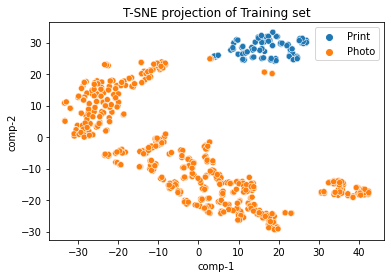

In [36]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
                data=df1).set(title="T-SNE projection of Training set")

[Text(0.5, 1.0, 'T-SNE projection of Test set')]

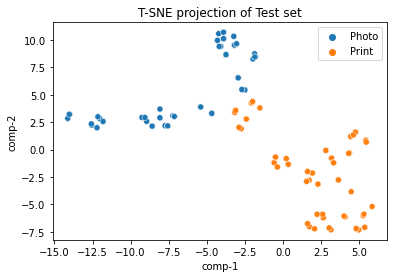

In [37]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                data=df2).set(title="T-SNE projection of Test set")

# There is clear seperation between the photo texture and print texture, especially with the larger training dataset.